## Загрузим данные

In [1]:
import polars as pl
from datetime import datetime

# === Пути к данным ===
TX_PATH = "transaction_fraud_data.parquet"
FX_PATH = "historical_currency_exchange.parquet"

# === Читаем транзакции (Lazy) ===
tx = pl.scan_parquet(TX_PATH)

# Быстрые базовые приведения
tx = tx.with_columns([
    pl.col("timestamp").cast(pl.Datetime(time_unit="us")).alias("timestamp"),
    pl.col("is_fraud").cast(pl.Int8).alias("is_fraud_num"),  # для агрегатов
    pl.col("currency").cast(pl.Utf8),
])

# 1) Обогатить: распаковываем вложенную struct "last_hour_activity"
# Даст колонки: num_transactions, total_amount, unique_merchants, unique_countries, max_single_amount
tx = tx.unnest("last_hour_activity")

# Дата для джойна с курсами
tx = tx.with_columns([
    pl.col("timestamp").dt.date().alias("date"),
    pl.col("timestamp").dt.hour().alias("hour"),
    pl.col("timestamp").dt.weekday().alias("weekday"),  # 0=Пн ... 6=Вс
])

## Перевод всех транзакций в USD по таблице курсов

In [2]:
# Читаем курсы (Lazy)
fx = pl.scan_parquet(FX_PATH)

# Приводим к long-формату: date | currency | rate
fx_long = (
    fx.melt(id_vars="date", variable_name="currency", value_name="rate")
    .with_columns([
        pl.col("currency").cast(pl.Utf8),
        pl.col("rate").cast(pl.Float64)
    ])
)

# Джойн транзакций с курсами по дате и валюте
tx_fx = (
    tx.join(fx_long, on=["date", "currency"], how="left")
      .with_columns([
          # amount_usd = amount / rate; если currency=USD, rate=1 — всё ок
          (pl.col("amount") / pl.col("rate")).alias("amount_usd")
      ])
)

# На случай пропусков курсов (редкие валюты или отсутствие даты в таблице)
tx_fx = tx_fx.with_columns([
    pl.when(pl.col("amount_usd").is_null())
      .then(pl.when(pl.col("currency")=="USD").then(pl.col("amount"))
            .otherwise(None))
      .otherwise(pl.col("amount_usd"))
      .alias("amount_usd")
])


C:\Users\tigra\AppData\Local\Temp\ipykernel_13192\2084773058.py:6: DeprecationWarning: `LazyFrame.melt` is deprecated; use `LazyFrame.unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  fx.melt(id_vars="date", variable_name="currency", value_name="rate")


## Разведочный анализ (EDA): что влияет на мошенничество

In [3]:
# Собираем в память только для EDA-агрегатов (экономично)
tx_df = (
    tx_fx.select([
        "is_fraud", "is_fraud_num", "amount", "amount_usd", "vendor_category", "vendor_type",
        "country", "city", 'city_size', "card_type", "is_card_present", "device", "channel", 'currency',
        "is_outside_home_country", "is_high_risk_vendor", "is_weekend", "hour", "weekday",
        "num_transactions","total_amount","unique_merchants","unique_countries","max_single_amount"
    ])
    .collect()
)

# Общий уровень мошенничества
overall = tx_df.select(pl.col("is_fraud_num").mean().alias("fraud_rate_overall"))

# По времени
by_hour = (
    tx_df.group_by("hour")
         .agg([pl.len().alias("n"),
               pl.col("is_fraud_num").mean().alias("fraud_rate")])
         .sort("hour")
)

by_weekday = (
    tx_df.group_by("weekday")
         .agg([pl.len().alias("n"),
               pl.col("is_fraud_num").mean().alias("fraud_rate")])
         .sort("weekday")
)

# Категориальные признаки
cat_cols = ["channel","device","vendor_category","card_type","country",
            "is_card_present","is_outside_home_country","is_high_risk_vendor","is_weekend"]

eda_tables = {}
for c in cat_cols:
    tbl = (
        tx_df.group_by(c)
             .agg([
                 pl.len().alias("n"),
                 pl.col("is_fraud_num").mean().alias("fraud_rate")
             ])
             .sort("fraud_rate", descending=True)  # <— вот так
             # .sort(by=pl.col("fraud_rate"), descending=True)  # альтернативный синтаксис
    )
    eda_tables[c] = tbl


# Влияние суммы: бинируем по квантилям
# 1) Квантили только по непустым amount_usd
q20, q40, q60, q80 = (
    tx_df.filter(pl.col("amount_usd").is_not_null())
         .select([
             pl.col("amount_usd").quantile(0.2).alias("q20"),
             pl.col("amount_usd").quantile(0.4).alias("q40"),
             pl.col("amount_usd").quantile(0.6).alias("q60"),
             pl.col("amount_usd").quantile(0.8).alias("q80"),
         ])
         .row(0)
)

# 2) Биннинг — ВСЕ строковые метки через pl.lit(...)
tx_df = tx_df.with_columns([
    pl.when(pl.col("amount_usd").is_null()).then(pl.lit("missing"))      # опционально: отдельный бин для NULL
     .when(pl.col("amount_usd") <= q20).then(pl.lit("q1"))
     .when(pl.col("amount_usd") <= q40).then(pl.lit("q2"))
     .when(pl.col("amount_usd") <= q60).then(pl.lit("q3"))
     .when(pl.col("amount_usd") <= q80).then(pl.lit("q4"))
     .otherwise(pl.lit("q5"))
     .alias("amount_usd_bin")
])

by_amount_bin = (
    tx_df.group_by("amount_usd_bin")
         .agg([
             pl.len().alias("n"),
             pl.col("is_fraud_num").mean().alias("fraud_rate")
         ])
         .sort("amount_usd_bin")  # если хочешь порядок q1..q5..missing — можно кастануть в Categorical и задать порядок
)

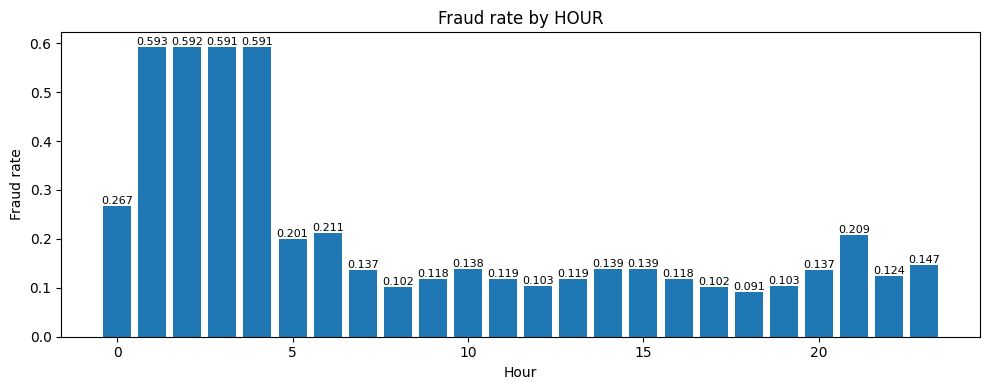

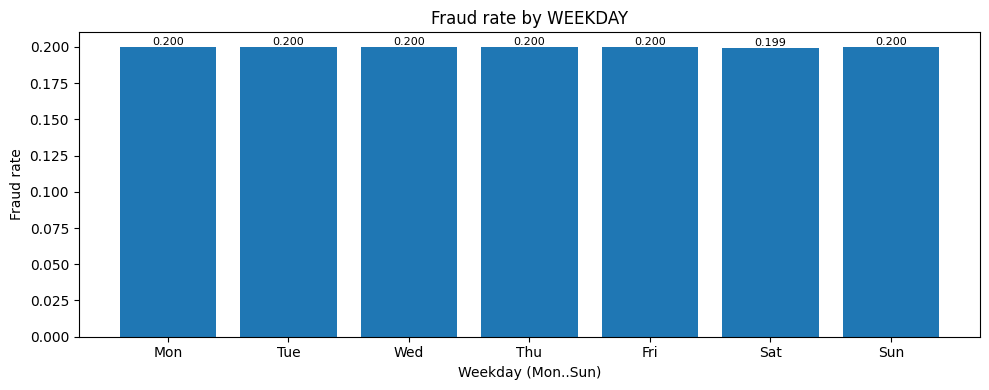

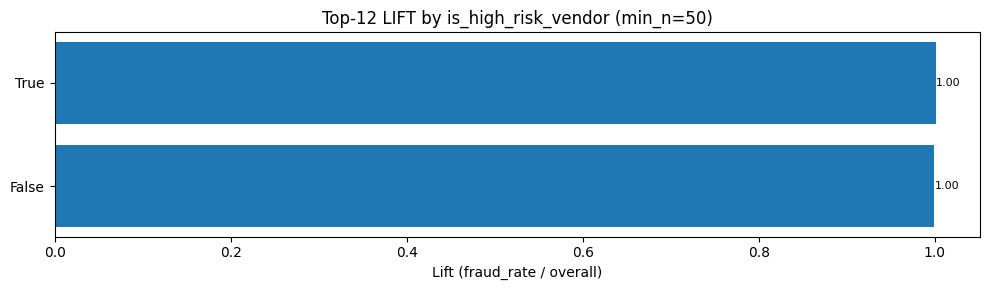

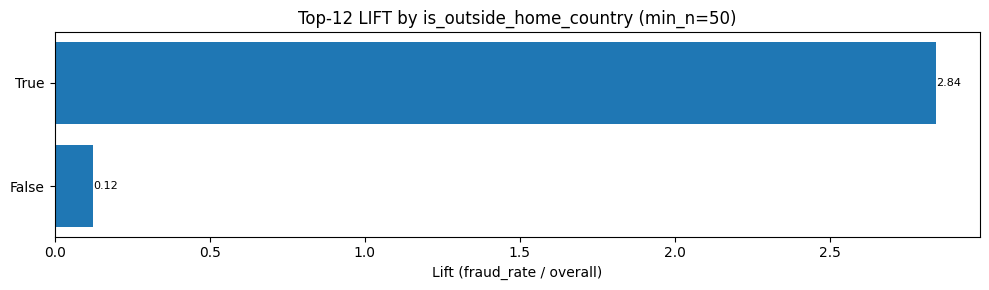

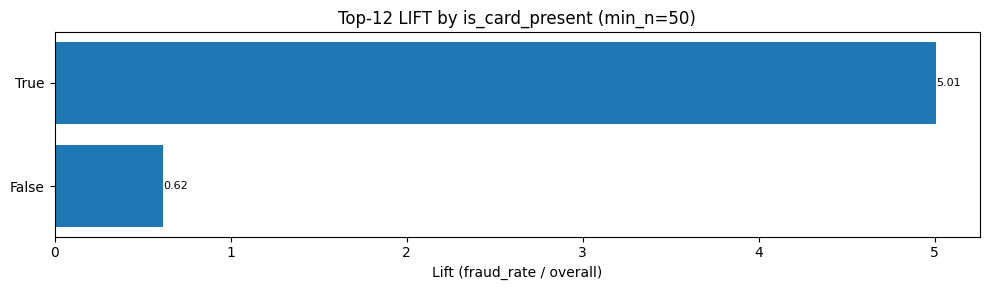

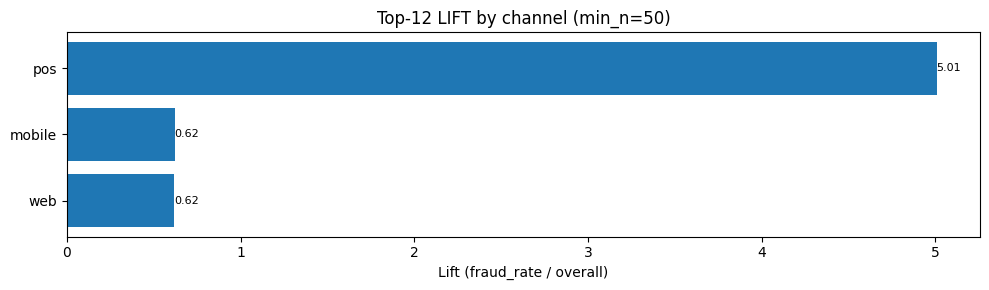

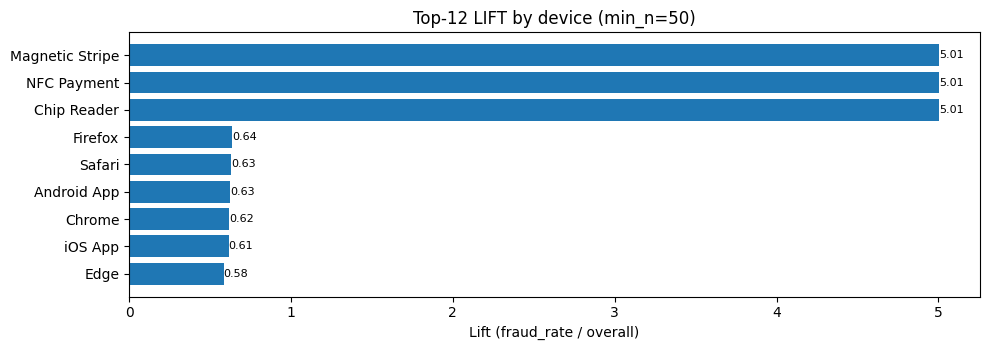

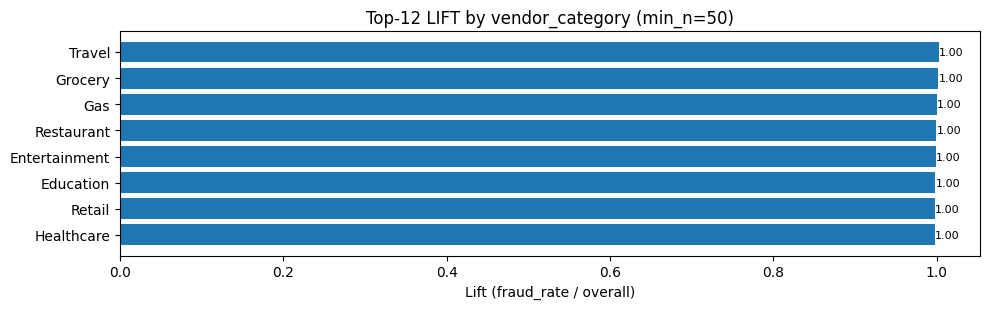

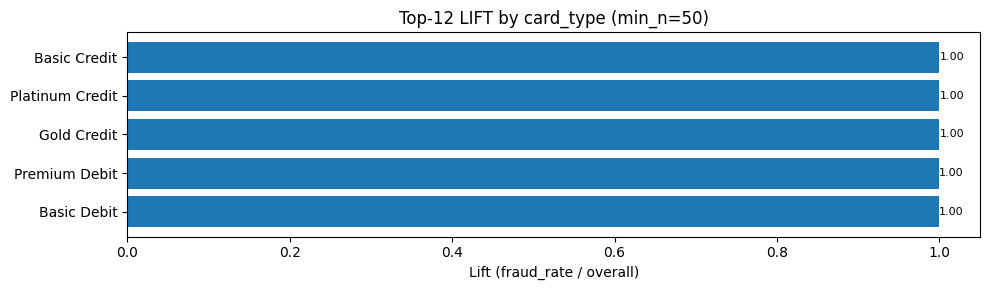

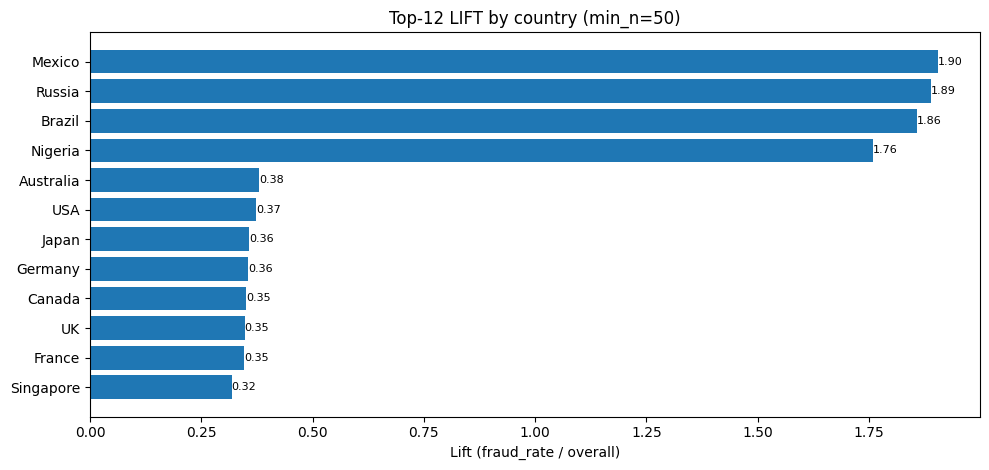

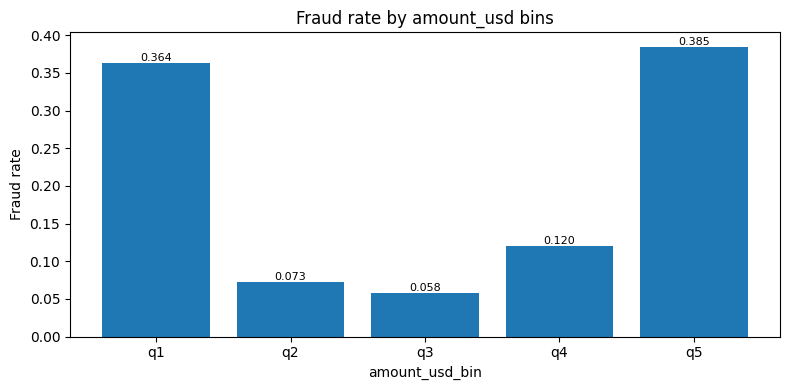

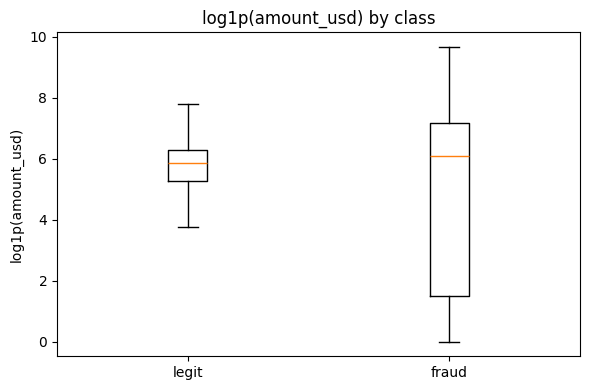

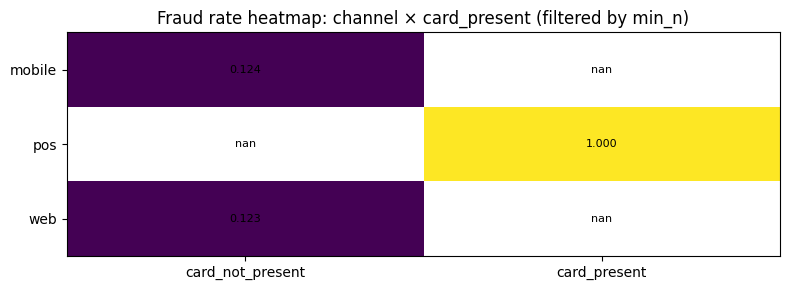

Готово. PNG-файлы лежат в: E:\PythonProjects\МО\eda_charts


In [4]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# === Настройки ===
OUTDIR = Path("eda_charts")
OUTDIR.mkdir(exist_ok=True)
MIN_N = 50        # минимальная поддержка категории/ячейки
TOP_K = 12        # сколько топ-категорий показывать

# защита: если is_weekend не было — создадим из weekday
if "is_weekend" not in tx_df.columns:
    tx_df = tx_df.with_columns((pl.col("weekday").is_in([5, 6])).cast(pl.Int8).alias("is_weekend"))

fraud_rate_overall = tx_df.select(pl.col("is_fraud_num").mean()).item()

def _save_show(fig, name: str):
    fig.tight_layout()
    fig.savefig(OUTDIR / f"{name}.png", dpi=160)
    plt.show()
    plt.close(fig)

# === 1) По часам ===
def plot_by_hour(df: pl.DataFrame):
    tbl = (df.group_by("hour")
             .agg(pl.len().alias("n"), pl.col("is_fraud_num").mean().alias("fraud_rate"))
             .sort("hour")
             .to_pandas())
    fig, ax = plt.subplots(figsize=(10,4))
    ax.bar(tbl["hour"], tbl["fraud_rate"])
    ax.set_title("Fraud rate by HOUR")
    ax.set_xlabel("Hour")
    ax.set_ylabel("Fraud rate")
    for i, v in enumerate(tbl["fraud_rate"]):
        ax.text(tbl["hour"].iloc[i], v, f"{v:.3f}", ha="center", va="bottom", fontsize=8, rotation=0)
    _save_show(fig, "01_fraud_by_hour")

# === 2) По дням недели ===
def plot_by_weekday(df: pl.DataFrame):
    # 0=Mon,...,6=Sun
    tbl = (df.group_by("weekday")
             .agg(pl.len().alias("n"), pl.col("is_fraud_num").mean().alias("fraud_rate"))
             .sort("weekday")
             .to_pandas())
    labels = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
    fig, ax = plt.subplots(figsize=(10,4))
    ax.bar(range(7), tbl["fraud_rate"])
    ax.set_title("Fraud rate by WEEKDAY")
    ax.set_xlabel("Weekday (Mon..Sun)")
    ax.set_ylabel("Fraud rate")
    ax.set_xticks(range(7))
    ax.set_xticklabels(labels)
    for i, v in enumerate(tbl["fraud_rate"]):
        ax.text(i, v, f"{v:.3f}", ha="center", va="bottom", fontsize=8)
    _save_show(fig, "02_fraud_by_weekday")

# === 3) ТОП категорий по lift (fraud_rate / overall) с отсевом редких ===
def plot_top_lift(df: pl.DataFrame, col: str, min_n: int = MIN_N, top_k: int = TOP_K):
    tbl = (df.group_by(col)
              .agg(pl.len().alias("n"), pl.col("is_fraud_num").mean().alias("fraud_rate"))
              .filter(pl.col("n") >= min_n)
              .with_columns((pl.col("fraud_rate") / fraud_rate_overall).alias("lift"))
              .sort("lift", descending=True)
              .head(top_k)
              .to_pandas())
    if tbl.empty:
        return
    fig, ax = plt.subplots(figsize=(10, max(3, 0.4*len(tbl))))
    y = np.arange(len(tbl))
    ax.barh(y, tbl["lift"])
    ax.set_yticks(y)
    ax.set_yticklabels([str(x) for x in tbl[col]])
    ax.invert_yaxis()
    ax.set_title(f"Top-{top_k} LIFT by {col} (min_n={min_n})")
    ax.set_xlabel("Lift (fraud_rate / overall)")
    for i, v in enumerate(tbl["lift"]):
        ax.text(v, i, f"{v:.2f}", va="center", ha="left", fontsize=8)
    _save_show(fig, f"03_lift_{col}")

# === 4) Сумма: квантильные бины + boxplot ===
def plot_amount_bins_and_box(df: pl.DataFrame):
    # Биннинг по квантилям на not-null
    nonnull = df.filter(pl.col("amount_usd").is_not_null())
    if nonnull.height == 0:
        return
    q20, q40, q60, q80 = (
        nonnull.select([
            pl.col("amount_usd").quantile(0.2).alias("q20"),
            pl.col("amount_usd").quantile(0.4).alias("q40"),
            pl.col("amount_usd").quantile(0.6).alias("q60"),
            pl.col("amount_usd").quantile(0.8).alias("q80"),
        ]).row(0)
    )
    df2 = df.with_columns([
        pl.when(pl.col("amount_usd").is_null()).then(pl.lit("missing"))
         .when(pl.col("amount_usd") <= q20).then(pl.lit("q1"))
         .when(pl.col("amount_usd") <= q40).then(pl.lit("q2"))
         .when(pl.col("amount_usd") <= q60).then(pl.lit("q3"))
         .when(pl.col("amount_usd") <= q80).then(pl.lit("q4"))
         .otherwise(pl.lit("q5"))
         .alias("amount_usd_bin")
    ])
    bins_tbl = (df2.group_by("amount_usd_bin")
                  .agg(pl.len().alias("n"), pl.col("is_fraud_num").mean().alias("fraud_rate"))
                  .sort("amount_usd_bin")
                  .to_pandas())
    # Бар по биннам
    fig, ax = plt.subplots(figsize=(8,4))
    ax.bar(bins_tbl["amount_usd_bin"], bins_tbl["fraud_rate"])
    ax.set_title("Fraud rate by amount_usd bins")
    ax.set_xlabel("amount_usd_bin")
    ax.set_ylabel("Fraud rate")
    for i, v in enumerate(bins_tbl["fraud_rate"]):
        ax.text(i, v, f"{v:.3f}", ha="center", va="bottom", fontsize=8)
    _save_show(fig, "04_fraud_by_amount_bins")

    # Boxplot по классам (не забудем лог)
    pdf = df.filter(pl.col("amount_usd").is_not_null()).select(["amount_usd","is_fraud_num"]).to_pandas()
    pdf["log_amount_usd"] = np.log1p(pdf["amount_usd"])
    data0 = pdf.loc[pdf["is_fraud_num"]==0, "log_amount_usd"].values
    data1 = pdf.loc[pdf["is_fraud_num"]==1, "log_amount_usd"].values
    if len(data0) > 0 and len(data1) > 0:
        fig, ax = plt.subplots(figsize=(6,4))
        ax.boxplot([data0, data1], labels=["legit","fraud"], showfliers=False)
        ax.set_title("log1p(amount_usd) by class")
        ax.set_ylabel("log1p(amount_usd)")
        _save_show(fig, "05_boxplot_log_amount_by_class")

# === 5) 2D-срез: тепловая карта channel × is_card_present (fraud rate) ===
def plot_heatmap_channel_cardpresent(df: pl.DataFrame, min_n: int = MIN_N):
    if ("channel" not in df.columns) or ("is_card_present" not in df.columns):
        return
    tbl = (df.group_by(["channel","is_card_present"])
             .agg(pl.len().alias("n"), pl.col("is_fraud_num").mean().alias("fraud_rate"))
             .filter(pl.col("n") >= min_n)
             .to_pandas())
    if tbl.empty:
        return
    # строим сводную fraud_rate
    pivot = tbl.pivot(index="channel", columns="is_card_present", values="fraud_rate")
    # имена столбцов для понятности
    pivot = pivot.rename(columns={0:"card_not_present", 1:"card_present"})
    fig, ax = plt.subplots(figsize=(8, max(3, 0.4*len(pivot))))
    im = ax.imshow(pivot.values, aspect="auto")
    ax.set_xticks(range(pivot.shape[1]))
    ax.set_xticklabels(pivot.columns.tolist(), rotation=0)
    ax.set_yticks(range(pivot.shape[0]))
    ax.set_yticklabels(pivot.index.tolist())
    ax.set_title("Fraud rate heatmap: channel × card_present (filtered by min_n)")
    # подписи ячеек
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = pivot.values[i, j]
            ax.text(j, i, f"{val:.3f}", ha="center", va="center", fontsize=8)
    _save_show(fig, "06_heatmap_channel_cardpresent")

# === Запуск всех графиков ===
plot_by_hour(tx_df)
plot_by_weekday(tx_df)

for col in ["is_high_risk_vendor","is_outside_home_country","is_card_present",
            "channel","device","vendor_category","card_type","country"]:
    if col in tx_df.columns:
        plot_top_lift(tx_df, col, min_n=MIN_N, top_k=TOP_K)

plot_amount_bins_and_box(tx_df)
plot_heatmap_channel_cardpresent(tx_df, min_n=MIN_N)

print(f"Готово. PNG-файлы лежат в: {OUTDIR.resolve()}")


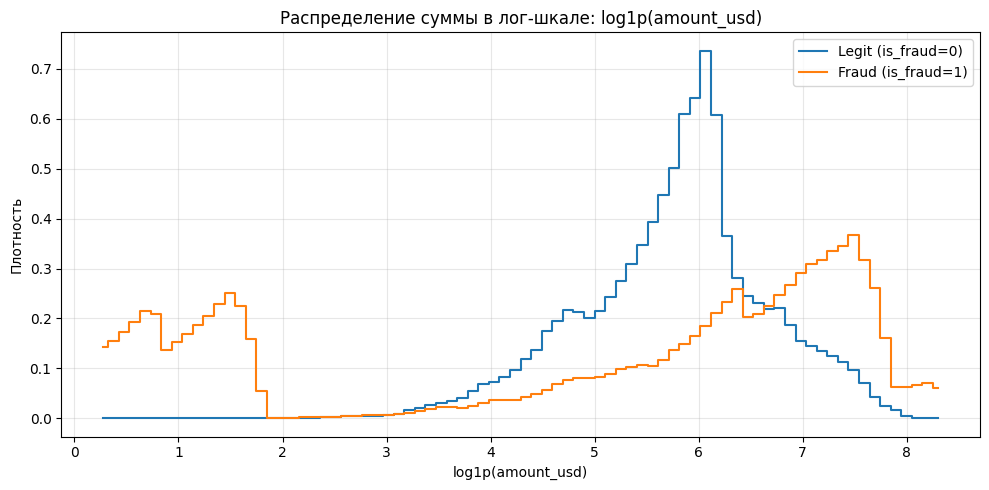

In [5]:
# === Распределение суммы в лог-шкале для fraud vs legit ===
def plot_log_amount_density(df: pl.DataFrame, nbins: int = 80, q_low: float = 0.005, q_high: float = 0.995):
    # Нужные колонки
    if ("amount_usd" not in df.columns) or ("is_fraud_num" not in df.columns):
        return

    pdf = (
        df.select(["amount_usd","is_fraud_num"])
          .filter(pl.col("amount_usd").is_not_null())
          .to_pandas()
    )
    if pdf.empty:
        return

    # log1p и чистка
    import numpy as np, matplotlib.pyplot as plt
    x = np.log1p(pdf["amount_usd"].astype("float64").to_numpy())
    y = pdf["is_fraud_num"].astype("int32").to_numpy()
    mask = np.isfinite(x)
    x, y = x[mask], y[mask]

    if x.size == 0:
        return

    # Общие бины по квантилям (чтобы хвосты не «съели» график)
    lo, hi = np.quantile(x, [q_low, q_high]) if x.size > 1000 else (x.min(), x.max())
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        lo, hi = x.min(), x.max() + 1e-6
    bins = np.linspace(lo, hi, nbins + 1)

    def density(values, bins):
        cnt, edges = np.histogram(values, bins=bins, density=True)
        mids = (edges[:-1] + edges[1:]) / 2.0
        return mids, cnt

    xf = x[y == 1]
    xl = x[y == 0]
    if xf.size == 0 or xl.size == 0:
        return

    xm_l, d_l = density(xl, bins)
    xm_f, d_f = density(xf, bins)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.step(xm_l, d_l, where="mid", linewidth=1.5, label="Legit (is_fraud=0)")
    ax.step(xm_f, d_f, where="mid", linewidth=1.5, label="Fraud (is_fraud=1)")
    ax.set_title("Распределение суммы в лог-шкале: log1p(amount_usd)")
    ax.set_xlabel("log1p(amount_usd)")
    ax.set_ylabel("Плотность")
    ax.grid(True, alpha=0.3)
    ax.legend()

    _save_show(fig, "07_log_amount_density")

# === Вызов (в твоём месте запуска графиков) ===
plot_log_amount_density(tx_df)


### Аномалии/паттерны риска

1) Канал POS — исключаем из обучения

На теплокарте по сочетанию канал × предъявление карты POS даёт фактически 100% мошенничества. Это признак, который напрямую связан с меткой и ломает обобщаемость модели.
Что делаем: полностью убираем channel = "pos" из обучающей выборки и настраиваем для POS отдельный контур (простое правило или отдельная модель).

Дополнительно: не тянуть в основную (web/mobile) модель признаки, которые фактически дублируют POS.

2) «Карта предъявлена» и POS-устройства — дубликаты POS

is_card_present = True и устройства вроде Magnetic Stripe / Chip Reader / NFC дают такой же сверхвысокий риск, потому что это, по сути, те же POS-сценарии.
Что делаем: после удаления POS-транзакций удаляем из фичей is_card_present и все POS-устройства — для web/mobile они превращаются в «почти константы» и только мешают.

3) Время суток

Самые высокие пики мошенничества — ночью (01–04), чуть повышено около 21:00.

4) География

Повышенный риск для Mexico, Russia, Brazil, Nigeria; для ряда развитых стран — ниже среднего. Флаг «вне домашней страны» даёт сильный прирост.

5) Суммы

Из графика распределения видно сгущение в одной области для мошеннических операций.

### Гипотезы

* **География — сильный сигнал.** По коду видно высокий разброс fraud-rate и лифты при достаточной поддержке для `is_outside_home_country`, `country` и прокси-гео `currency`: зарубежные операции и отдельные страны/валюты резко повышают риск — эти поля обязательны к использованию и сегментации порога.
* **Поведенческие — слабые.** Для `vendor_category`, `card_type`, `is_weekend`, `weekday`, `city_size` и **`vendor_type` медианы у фрода и легита почти совпадают, а разброс долей минимален.

In [16]:
# =========================
# ПАРАМЕТРЫ
# =========================
MIN_N = 500        # мин. поддержка для лифтов
SAMPLE_FRAC = 0.10 # доля сэмпла для медиан
SEED = 42

# =========================
# ХЕЛПЕРЫ
# =========================
def safe_cols(df, cols):
    return [c for c in cols if c in df.columns]

def calculate_fraud_rate_spread(df: pl.DataFrame, column_name: str):
    """std разброса fraud_rate по категориям признака"""
    if column_name not in df.columns:
        print(f"[skip] нет колонки '{column_name}'")
        return
    tbl = (df.group_by(column_name)
             .agg(fraud_rate = pl.col('is_fraud').mean(),
                  n          = pl.len())
             .filter(pl.col("n") > 0))
    if tbl.height == 0:
        print(f"[skip] пусто по '{column_name}'")
        return
    spread = tbl.select(pl.col("fraud_rate").std()).item()
    print(f"Разброс (std) для '{column_name}': {spread:.4f} (категорий: {tbl.height})")

def lift_table(df: pl.DataFrame, col: str, min_n: int = MIN_N, top_k: int = 10):
    """Лифт по категориальному признаку с отсечкой по поддержке"""
    if col not in df.columns:
        print(f"[skip] нет колонки '{col}'")
        return None
    overall = float(df.select(pl.col("is_fraud").mean()).item())
    res = (df.group_by(col)
             .agg(n = pl.len(), fr = pl.col("is_fraud").mean())
             .with_columns(lift = pl.col("fr")/overall)
             .filter(pl.col("n") >= min_n)
             .sort(pl.col("lift"), descending=True)
             .head(top_k))
    if res.height == 0:
        print(f"[{col}] поддержка < {min_n}")
        return None
    print(f"\nTop лифтов по '{col}' (min_n={min_n}):")
    print(res.to_pandas().to_string(index=False))
    return res

def compare_behavior_medians(df: pl.DataFrame):
    """Медианы поведенческих (старые имена) по классам (на сэмпле)"""
    beh_cols = safe_cols(df, [
        'num_transactions','total_amount','unique_merchants','unique_countries','max_single_amount'
    ])
    if not beh_cols:
        print("[skip] нет поведенческих колонок")
        return
    sample = df.sample(fraction=SAMPLE_FRAC, seed=SEED) if df.height > 200_000 else df
    med = (sample.group_by('is_fraud')
                 .agg([pl.median(c).alias(f"median_{c}") for c in beh_cols])
                 .sort('is_fraud'))
    print("\nМедианы поведенческих (сэмпл):")
    print(med.to_pandas().to_string(index=False))

# =========================
# ШАГ 1. ОЧИСТКА
# =========================
print("--- Шаг 1: Очистка данных ---")

df_all = (
    tx_fx.select([
        "timestamp", "is_fraud", "channel",
        'amount', "num_transactions","total_amount","unique_merchants","unique_countries","max_single_amount",
        'amount_usd', 'hour', 'weekday', "is_outside_home_country",
        "is_high_risk_vendor", 'vendor_category', 'vendor_type', 'currency', 'country', 'city_size', 'card_type', 'device'
    ])
    .with_columns((pl.col("weekday").is_in([5,6])).cast(pl.Int8).alias("is_weekend"))
    .collect()
)

assert 'df_all' in globals(), "Ожидаю df_all (Polars DataFrame)."
print(f"Размер датасета до очистки: {df_all.shape}")

df_clean = df_all

# 1) удаляем дубликаты по transaction_id (если колонка есть)
if 'transaction_id' in df_clean.columns:
    df_clean = df_clean.unique(subset=['transaction_id'], keep='first')

# 2) убираем заведомые утечки/прокси POS
leakage_columns = ['channel', 'is_card_present']
df_clean = df_clean.drop(safe_cols(df_clean, leakage_columns))

print(f"Итоговый размер очищенного датасета: {df_clean.shape}\n")

# =========================
# ШАГ 2. ПРОВЕРКА ГИПОТЕЗ
# =========================
print("--- Проверка гипотез: сила предикторов ---")
print("Сильные (ожидаем большой разброс):")
for c in ['is_outside_home_country','country','currency','vendor_type','hour']:
    calculate_fraud_rate_spread(df_clean, c)

print("\nСлабые (ожидаем малый разброс):")
for c in ['vendor_category','card_type','device','city_size','is_weekend','weekday']:
    calculate_fraud_rate_spread(df_clean, c)

print("\n--- Поведенческие признаки (старые имена) ---")
compare_behavior_medians(df_clean)

# Дополнительно: лифты по ключам
_ = lift_table(df_clean, 'country', MIN_N, 10)
_ = lift_table(df_clean, 'currency', MIN_N, 10)
_ = lift_table(df_clean, 'vendor_type', MIN_N, 10)
_ = lift_table(df_clean, 'hour',     5000,  24)


--- Шаг 1: Очистка данных ---
Размер датасета до очистки: (7483766, 22)
Итоговый размер очищенного датасета: (7483766, 21)

--- Проверка гипотез: сила предикторов ---
Сильные (ожидаем большой разброс):
Разброс (std) для 'is_outside_home_country': 0.3839 (категорий: 2)
Разброс (std) для 'country': 0.1476 (категорий: 12)
Разброс (std) для 'currency': 0.1512 (категорий: 11)
Разброс (std) для 'vendor_type': 0.0006 (категорий: 17)
Разброс (std) для 'hour': 0.1765 (категорий: 24)

Слабые (ожидаем малый разброс):
Разброс (std) для 'vendor_category': 0.0004 (категорий: 8)
Разброс (std) для 'card_type': 0.0000 (категорий: 5)
Разброс (std) для 'device': 0.4382 (категорий: 9)
Разброс (std) для 'city_size': 0.0909 (категорий: 2)
Разброс (std) для 'is_weekend': 0.0002 (категорий: 2)
Разброс (std) для 'weekday': 0.0002 (категорий: 7)

--- Поведенческие признаки (старые имена) ---

Медианы поведенческих (сэмпл):
 is_fraud  median_num_transactions  median_total_amount  median_unique_merchants  median_

### 1) География/время — сильный сигнал

`is_outside_home_country` даёт крупнейший разброс (std **0.3839**), а по `country`/`currency` лифты до **\~1.9×** (Mexico, Russia, Brazil, Nigeria — топ-риск), плюс ночные часы **01–04** с лифтом **\~3×** — эти признаки держат основную мощь модели и требуют отдельной пороговой политики.

### 2) Слабые/бесполезные признаки (переписано по результатам)

`vendor_category`, `card_type`, `is_weekend`, `weekday`, `city_size` и **`vendor_type`** показывают мизерный разброс (std ≈ 0.0000–0.0909), а поведенка (`num_transactions`, `total_amount`, `unique_*`, `max_single_amount`) по медианам у фрода и легита почти одинаковая (**291–296**, **1.01e7–1.04e7** и т.д.) — их вклад в детекцию минимален, можно урезать без потери качества.


## Обучение модели

1. Выбор признаков: исключаем ID, channel='pos' и POS-прокси (is_card_present, POS-девайсы), оставляем исходные числовые/бинарные/категориальные поля.

2. Разделение данных: делим по времени 80/20 без перемешивания, чтобы эмулировать прод-сценарий.

3. Модель/конвейер: используем CatBoost с нативными категориальными (без OHE), включаем баланс классов и early stopping.

4. Обучение и оценка: обучаем на train и на test считаем PR-AUC/ROC-AUC, а также precision/recall/F1 при порогах @precision≥95% и @maxF1.

In [8]:
# === TRAIN 4 MODELS + расширенные метрики (ROC/PR-AUC, precision/recall/F1 @thr95 и @maxF1) ===
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    confusion_matrix, precision_score, recall_score, f1_score
)
from catboost import CatBoostClassifier, Pool

# Ожидается df_all (или tx_fx -> собери df_all как у тебя выше)
df_all = (
    tx_fx.select([
        "timestamp", "is_fraud", "channel",
        'amount', "num_transactions","total_amount","unique_merchants","unique_countries","max_single_amount",
        'amount_usd', 'hour', 'weekday', "is_outside_home_country",
        "is_high_risk_vendor", 'vendor_category', 'vendor_type', 'currency', 'country', 'city_size', 'card_type', 'device'
    ])
    .with_columns((pl.col("weekday").is_in([5,6])).cast(pl.Int8).alias("is_weekend"))
    .collect()
)

# 1) Срез/очистка: убираем POS и прокси POS (оставляем только digital)
POS_DEVICES = {"Magnetic Stripe","Chip Reader","NFC Payment"}
df_base = (
    df_all
    .filter(pl.col("channel") != "pos")
    .with_columns(
        pl.when(pl.col("device").is_in(list(POS_DEVICES))).then(pl.lit(None)).otherwise(pl.col("device")).alias("device")
    )
)

# 2) Списки исходных колонок (СТАРЫЕ ПОЛЯ, без новых фичей)
num_candidates = [
    "num_transactions","total_amount","unique_merchants","unique_countries","max_single_amount", 'amount_usd', 'hour', 'weekday'
]
bin_candidates = [
    "is_outside_home_country",
    "is_high_risk_vendor","is_weekend"
]
cat_candidates = ['vendor_category', 'vendor_type', 'currency', 'country', 'city_size', 'card_type', 'device']
# Можно добавить/убрать поля выше — это именно «сырые» признаки из твоего датасета.

# Оставляем только те, что реально есть
num_cols = [c for c in (num_candidates + bin_candidates) if c in df_base.columns]
cat_cols = [c for c in cat_candidates if c in df_base.columns]

# 3) Сбор датасета под обучение
feats_base = df_base.select(["is_fraud"] + num_cols + cat_cols)
y = feats_base.select("is_fraud").to_series().to_numpy().astype(int)
X = feats_base.select(num_cols + cat_cols).to_pandas()

# Категории -> строки (и NA) для OHE/CatBoost
for c in cat_cols:
    X[c] = X[c].astype("string").fillna("NA")

# 4) Временной сплит 80/20 (без перемешивания)
ts = df_base.select("timestamp").to_pandas()["timestamp"]
order = np.argsort(pd.to_datetime(ts))
cut = int(0.8 * len(order))
train_idx, test_idx = order[:cut], order[cut:]

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print("Shapes:", X_train.shape, X_test.shape, "num_cols:", len(num_cols), "cat_cols:", len(cat_cols))
# Далее — твой обучающий блок моделей, используй X_train/X_test/y_train/y_test и cat_cols


# ---- OHE совместимый с разными версиями sklearn ----
def make_ohe(min_freq=100):
    try:
        return OneHotEncoder(handle_unknown="ignore", min_frequency=min_freq, sparse_output=True, dtype=np.float32)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", min_frequency=min_freq, sparse=True, dtype=np.float32)

# ---- поиск порогов и метрики ----
def pick_thr95_and_maxF1(y_true, scores, prec_target=0.95):
    p, r, thr = precision_recall_curve(y_true, scores)  # len(thr) = len(p)-1
    # thr95 (макс. recall при precision>=target)
    thr95 = rec95 = pre95 = None
    for i in range(len(thr)):
        if p[i] >= prec_target:
            if rec95 is None or r[i] > rec95:
                rec95, pre95, thr95 = r[i], p[i], thr[i]
    # thr@maxF1
    f1_best, thr_f1, pre_f1, rec_f1 = -1.0, None, None, None
    for i in range(len(thr)):
        f1 = (2*p[i]*r[i] / (p[i]+r[i])) if (p[i]+r[i])>0 else 0.0
        if f1 > f1_best:
            f1_best, thr_f1, pre_f1, rec_f1 = f1, thr[i], p[i], r[i]
    return (thr95, pre95, rec95), (thr_f1, pre_f1, rec_f1)

def eval_all(y_true, scores, prec_target=0.95):
    out = {
        "ROC_AUC": float(roc_auc_score(y_true, scores)),
        "PR_AUC": float(average_precision_score(y_true, scores)),
    }
    (thr95, pre95, rec95), (thr_f1, pre_f1, rec_f1) = pick_thr95_and_maxF1(y_true, scores, prec_target)

    # --- метрики @thr95 ---
    if thr95 is not None:
        yhat95 = (scores >= thr95).astype(int)
        out.update({
            "thr@p>=0.95": float(thr95),
            "precision@thr95": float(precision_score(y_true, yhat95, zero_division=0)),
            "recall@thr95": float(recall_score(y_true, yhat95, zero_division=0)),
            "F1@thr95": float(f1_score(y_true, yhat95, zero_division=0)),
            "cm@thr95": confusion_matrix(y_true, yhat95, labels=[0,1]),
        })
    else:
        out.update({"thr@p>=0.95": None, "precision@thr95": 0.0, "recall@thr95": 0.0, "F1@thr95": 0.0, "cm@thr95": None})

    # --- метрики @maxF1 ---
    if thr_f1 is not None:
        yhat_f1 = (scores >= thr_f1).astype(int)
        out.update({
            "thr@maxF1": float(thr_f1),
            "precision@maxF1": float(precision_score(y_true, yhat_f1, zero_division=0)),
            "recall@maxF1": float(recall_score(y_true, yhat_f1, zero_division=0)),
            "F1@maxF1": float(f1_score(y_true, yhat_f1, zero_division=0)),
            "cm@maxF1": confusion_matrix(y_true, yhat_f1, labels=[0,1]),
        })
    else:
        out.update({"thr@maxF1": None, "precision@maxF1": 0.0, "recall@maxF1": 0.0, "F1@maxF1": 0.0, "cm@maxF1": None})
    return out

results = {}


Shapes: (5466175, 18) (1366544, 18) num_cols: 11 cat_cols: 7


In [9]:

# 3) CatBoost
cat_idx = [X.columns.get_loc(c) for c in cat_cols if c in X.columns]
train_pool = Pool(X_train, y_train, cat_features=cat_idx)
test_pool  = Pool(X_test,  y_test,  cat_features=cat_idx)
cat = CatBoostClassifier(
    iterations=50, random_seed=42
)
cat.fit(train_pool, eval_set=test_pool, use_best_model=True, verbose=200)
p_cat = cat.predict_proba(test_pool)[:,1]
results["CatBoost"] = eval_all(y_test, p_cat)


Learning rate set to 0.5
0:	learn: 0.3777724	test: 0.3772868	best: 0.3772868 (0)	total: 1.15s	remaining: 56.3s
49:	learn: 0.0874192	test: 0.0889203	best: 0.0889203 (49)	total: 32.3s	remaining: 0us

bestTest = 0.08892029384
bestIteration = 49



In [10]:
# 4) Decision Tree (num-only)
Xn_train = X_train[[c for c in num_cols if c in X.columns]].fillna(0.0)
Xn_test  = X_test[[c for c in num_cols if c in X.columns]].fillna(0.0)
tree = DecisionTreeClassifier(max_depth=8, min_samples_leaf=200, class_weight="balanced", random_state=42)
tree.fit(Xn_train, y_train)
p_tree = tree.predict_proba(Xn_test)[:,1]
results["DecisionTree(num)"] = eval_all(y_test, p_tree)

In [11]:

# ---- сводная таблица (ключевые поля) ----
cols = ["ROC_AUC","PR_AUC",
        "precision@maxF1","recall@maxF1","F1@maxF1"]
summary = (pd.DataFrame(results).T[cols]
           .sort_values("PR_AUC", ascending=False))
print("\n=== METRICS (sorted by PR-AUC) ===")
print(summary.to_string(float_format=lambda x: f"{x:.4f}" if isinstance(x, float) else str(x)))

# ---- опционально: вывести confusion matrices ----
for name, res in results.items():
    print(f"\n[{name}] Confusion matrix @thr95:")
    print(res["cm@thr95"])
    print(f"[{name}] Confusion matrix @maxF1:")
    print(res["cm@maxF1"])


=== METRICS (sorted by PR-AUC) ===
                  ROC_AUC PR_AUC precision@maxF1 recall@maxF1 F1@maxF1
CatBoost           0.9859 0.9366          0.8705       0.8382   0.8540
DecisionTree(num)  0.9652 0.8579          0.8254       0.7325   0.7762

[CatBoost] Confusion matrix @thr95:
[[1192632    6447]
 [  44961  122504]]
[CatBoost] Confusion matrix @maxF1:
[[1178192   20887]
 [  27094  140371]]

[DecisionTree(num)] Confusion matrix @thr95:
[[1195483    3596]
 [  80012   87453]]
[DecisionTree(num)] Confusion matrix @maxF1:
[[1173130   25949]
 [  44804  122661]]


In [12]:

# Топ-важности CatBoost
imp = cat.get_feature_importance(type="FeatureImportance")
fi = pd.DataFrame({"feature": X.columns, "importance": imp}).sort_values("importance", ascending=False)
print("\nCatBoost: TOP-25 features")
print(fi.head(25).to_string(index=False))


CatBoost: TOP-25 features
                feature  importance
             amount_usd   34.158512
is_outside_home_country   18.982365
               currency   17.932446
            vendor_type   11.217026
                   hour    6.361939
              card_type    3.029463
    is_high_risk_vendor    2.759654
                country    1.845300
           total_amount    1.768247
       num_transactions    1.172516
      max_single_amount    0.489920
       unique_merchants    0.165651
       unique_countries    0.113350
              city_size    0.003611
             is_weekend    0.000000
        vendor_category    0.000000
                weekday    0.000000
                 device    0.000000


## Итоги

1. Интерпретация результатов модели

- PR-AUC = 0.9388: высокая качество ранжирования в редкой задаче — модель уверенно поднимает фрод наверх списка.

- ROC-AUC = 0.9864: почти идеальная сортировка классов; запас по качеству высокий.

- На пороге maxF1: Precision = 0.879 / Recall = 0.835 / F1 = 0.856 — сбалансированный режим для боевого применения; при смещении порога вверх можно добиться большей точности ценой охвата.

- Смысл по признакам: география(за границей) и суммы и валюта(косвенно отражает страну) — ключевые драйверы; POS исключён из обучающей выборки; «общебизнесовые» поля влияют слабее — их вес в решениях стоит ограничивать. 

2. Рекомендации

Для бизнеса:

- Внедрить CatBoost с целевым порогом под KPI (старт — maxF1, для строгой фильтрации — смещение к большей precision).

- Правила поверх модели: outside_home × крупная сумма и ночь × аномалия по сумме — в приоритетную эскалацию.

- Мониторинг прод-качества: еженедельно контролировать precision/recall/F1 и PR-AUC, отслеживать дрейф.